In [2]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, BertForSequenceClassification

Для реализации задачи обучение модели не требуется. Используем сразу валидационный датасет

In [4]:
valid = pd.read_csv("../../data/preprocessed/rubert/valid.csv")
reference = pd.read_csv("../../data/preprocessed/rubert/reference.csv")

In [5]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [6]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         305 non-null    int64 
 1   reference  305 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


### Преобразования в np.array

In [7]:
x = valid["name"].to_numpy(dtype="<U25").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="<U25").flatten()

# Построение модели

In [8]:
def find_matches_rubert(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []
    for x in x_vec:
        similarities = cosine_similarity(x.reshape(1, -1), reference_vec).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства
        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        y_pred.append(top_matches)
    return y_pred, manual_review

In [31]:
# Загрузка модели и токенизатора RuBERT
# model_name = "bert-base-uncased"
# model_name = "DeepPavlov/rubert-base-cased-conversational"
# model_name = "DeepPavlov/distilrubert-base-cased-conversational"
# model_name = "DeepPavlov/distilrubert-small-cased-conversational" # 0.7 error
# model_name = "DeepPavlov/t5-wikidata5M-with-neighbors"
model_name = "DeepPavlov/rubert-base-cased"


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


def embed_texts(texts, tokenizer, model):
    inputs = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    with torch.no_grad():
        outputs = model.bert(**inputs)
    # print(outputs)
    return outputs[0][:, 0, :].numpy()  # Получение скрытых состояний

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Векторизация текстов с использованием BERT
x_vec = embed_texts(x.tolist(), tokenizer, model)
reference_vec = embed_texts(reference_name.tolist(), tokenizer, model)

In [33]:
# Массив значений threshold
threshold_values = np.linspace(-0.1, 1.0, 10)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_rubert(
        x_vec, reference_id, reference_vec, top_k=5, threshold=threshold
    )
    metrics = mtc.calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

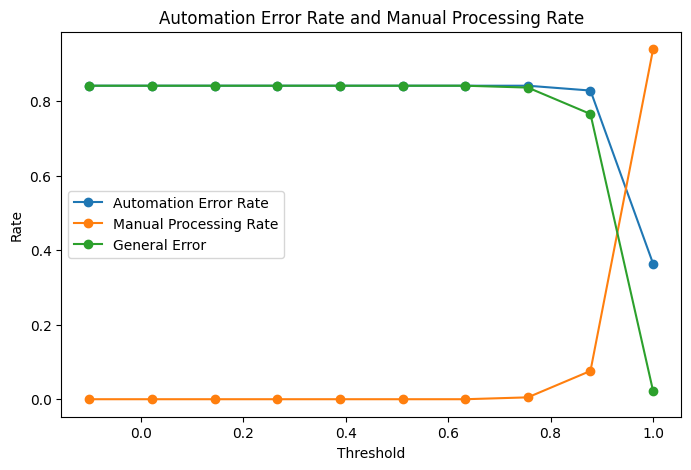

In [34]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [35]:
y_pred, manual_review = find_matches_rubert(
    x_vec, reference_id, reference_vec, top_k=5, threshold=-1
)

metrics = mtc.calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.158,
 'Accuracy@3': 0.239,
 'Accuracy@5': 0.288,
 'auto_error_rate': 0.842,
 'manual_processing_rate': 0.0,
 'general_error': 0.842}

: 